In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_cols(df, cols):
    return df[cols].T.values

In [3]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')

In [4]:
df_classify = pd.read_json('df_classify.json')
df = pd.read_json('df_stacked.json')

In [5]:
def pfit(x, y, deg=1):
    idx = np.where(~np.isnan(x) & ~np.isnan(y))

    _x = x[idx]
    _y = y[idx]

    xs = np.linspace(np.min(_x), np.max(_x), int(1e4))

    # build polynomial factors, sum them to get each value of y
    p = np.polyfit(_x, _y, deg)[::-1]
    ys = sum([p[i]*xs**i for i in range(len(p))])
    
    return xs, ys

In [6]:
def fit_color(r, g, votes, deg=1):
    idx = np.where(~np.isnan(r) & ~np.isnan(g) & ~np.isnan(votes))

    _g = g[idx]
    _r = r[idx]
    _votes = votes[idx]

    xs = np.linspace(np.min(_g-_r), np.max(_g-_r), int(1e4))

    # build polynomial factors, sum them to get each value of y
    p = np.polyfit(_g-_r, _votes, deg)[::-1]
    ys = sum([p[i]*xs**i for i in range(len(p))])
    
    return xs, ys

## Queries:

In [7]:
q_gal = "`% votes galaxy` > 75"
q_has_t9 = "T9.str.len() > 0"

## Extract vote percentages per task:

### First print unique answers:

In [8]:
tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
task_strings = ['T{}'.format(t) for t in tasks_hardcore]

In [9]:
for t in task_strings:
    print(t, df[t].unique().tolist())

T0 ['galaxy', 'group of objects (cluster)', 'something else/empty center']
T2 ['Impossible to say', 'White/blue', None, 'Red/yellow']
T1 ['Fluffy', None, 'Bright']
T3 ['No/Unsure', None, 'Yes, a bright point', 'Yes, a bulge']
T4 ['Distorted/disturbed', 'Elliptical', None, 'Round']
T5 [None, 'Smooth and fuzzy', 'Smooth and dense', 'Clumpy and/or featured']
T9 [None, 'Something else', 'Looks like a small star', 'Scattered light', 'Nothing: background too bright or galaxy too faint']


In [10]:
def get_answer_vote_percentage(row, entry, decimal_places=1):
    none_count = row.get('None', 0)
    total_votes = sum(row.values())
    actual_votes = total_votes - none_count
    
    if actual_votes > 0:
        return round(100*row.get(entry, 0)/actual_votes, decimal_places)

tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
task_strings = ['T{}'.format(t) for t in tasks_hardcore]
    
for task in task_strings:
    for entry in df.query("~{}.isnull()".format(task))[task].unique().tolist():
        df_votes["{} % {}".format(task, entry.lower())] = df_votes[task].apply(lambda x: get_answer_vote_percentage(x,  entry))
    
# for entry in df.query("~T2.isnull()")['T2'].unique().tolist():
#     df_votes["T2 % {}".format(entry.lower())] = df_votes['T2'].apply(lambda x: get_answer_vote_percentage(x,  entry))

In [11]:
for task in task_strings:
    for entry in df.query("~{}.isnull()".format(task))[task].unique().tolist():
        df_votes["{} % {}".format(task, entry.lower())] = df_votes[task].apply(lambda x: get_answer_vote_percentage(x,  entry))

In [12]:
def get_column_names(s, df):
    cols = df.columns.tolist()
    return list(filter(lambda x: x.startswith(s), cols))

### Plot task 5 answers (clumpy/fuzzy/dense) vs. concentration

In [13]:
t5cols = get_column_names('T5', df_votes)
print(t5cols)

['T5', 'T5 % smooth and fuzzy', 'T5 % smooth and dense', 'T5 % clumpy and/or featured']


In [14]:
fuzzy, dense, clumpy = t5cols[1:4]
C, fuzzy, dense, clumpy = get_cols(df_votes, ['C', fuzzy, dense, clumpy])

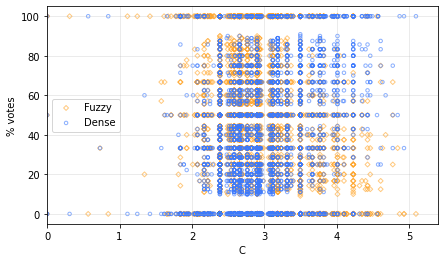

In [15]:
fig, fr = plt.subplots(figsize=(7,4))

fr.scatter(C, fuzzy, s=12, facecolor="none", edgecolor="xkcd:mango", alpha=0.6, marker="D", label='Fuzzy')
fr.scatter(C, dense, s=12, facecolor="none", edgecolor="xkcd:lightish blue", alpha=0.6, label='Dense')
fr.set_xlim(0, max(C)+0.3)
fr.set_ylabel('% votes')
fr.set_xlabel('C')
fr.legend()
fr.grid(alpha=0.3, which='both')
plt.show()

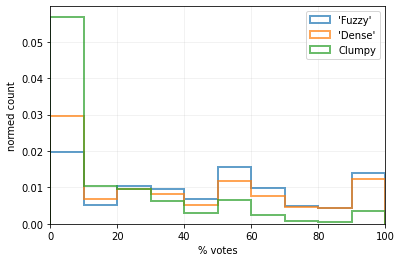

In [16]:
fig, fr = plt.subplots()

kwargs = { "histtype": "step", "lw": 2, "alpha": 0.7, "density": True }
fr.hist(fuzzy, **kwargs, label="'Fuzzy'")
fr.hist(dense, **kwargs, label="'Dense'")
fr.hist(clumpy, **kwargs, label='Clumpy')

fr.set_xlim([0,100])
fr.set_xlabel('% votes')
fr.set_ylabel('normed count')
fr.grid(which='major', alpha=0.2)
fr.legend()
plt.show()


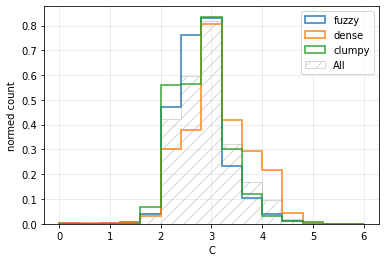

In [17]:
fig, fr = plt.subplots()

labels = ['fuzzy', 'dense', 'clumpy']
for index, i in enumerate(range(1,4)):
    c = df_votes.query("`{}` > 50".format(t5cols[i]))['C']
    fr.hist(c, range=[0, 6], density=True, histtype="step", alpha=0.8, lw=1.8, label=labels[index], bins=15)
    
fr.hist(df_votes['C'], range=[0,6], density=True, histtype='stepfilled', hatch='//', alpha=0.8, label='All',facecolor='None', edgecolor='#ccc', bins=15)
fr.legend()
fr.set_xlabel('C')
fr.set_ylabel('normed count')
fr.grid(alpha=0.3)
plt.show()

## Plot task 1 answers vs. photometric parameters

In [18]:
t1cols = get_column_names('T1', df_votes)
print(t1cols)

['T1', 'T1 % fluffy', 'T1 % bright']


In [19]:
r, g, i, mue_r, bright, fluffy = get_cols(df_votes, ['r', 'g', 'i', 'mue_r', *t1cols[1:]])

### r' [mag] vs. % votes fluffy/bright

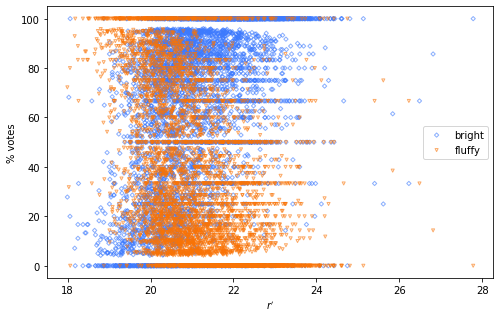

In [20]:
fig, fr = plt.subplots(figsize=(8,5))

kwargs = { "alpha": 0.6, "s": 9, "facecolor": "none"}

fr.scatter(r, bright, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="bright")
fr.scatter(r, fluffy, **kwargs, marker="v", edgecolor="xkcd:orange", label="fluffy")
fr.update({
    'xlabel': r"$r'$",
    "ylabel": '% votes'
})
fr.legend()
plt.show()

### g'-r' [mag] vs. % votes fluffy/bright

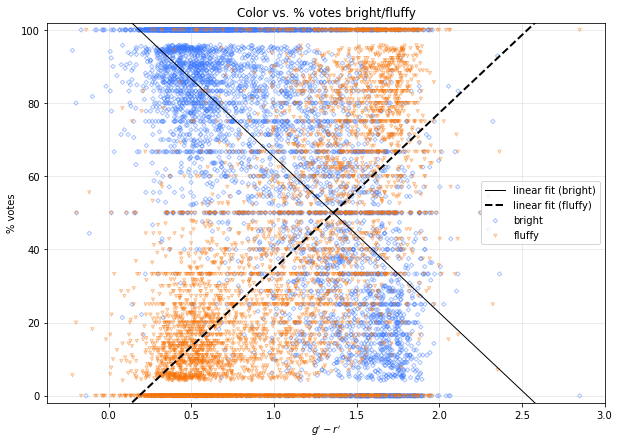

In [21]:
fig, fr = plt.subplots(figsize=(10, 7))

kwargs = { "alpha": 0.45, "s": 9, "facecolor": "none"}

fr.scatter(g-r, bright, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="bright")
fr.plot(*fit_color(r,g, bright), label='linear fit (bright)', lw=1, ls='-', c='black')

fr.scatter(g-r, fluffy, **kwargs, marker="v", edgecolor="xkcd:orange", label="fluffy")
fr.plot(*fit_color(r,g, fluffy), label='linear fit (fluffy)', lw=2, ls='--', c='black')

fr.update({
    'xlabel': r"$g'-r'$",
    "ylabel": '% votes',
    "ylim": [-2,102],
    "title": "Color vs. % votes bright/fluffy"
})
fr.legend()
fr.grid(alpha=0.3)
plt.show()

## Fluffy/bright vs. surface brightness

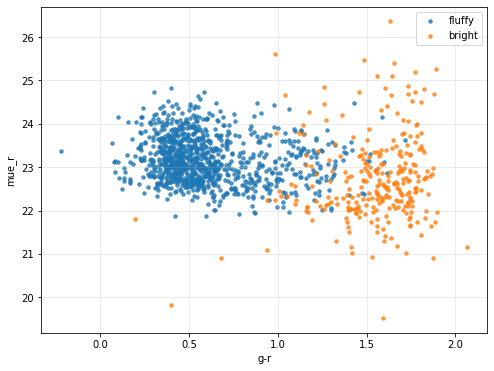

In [22]:
fluf = df_votes.query('`T0 % galaxy` > 75').query('`T1 % fluffy` > 75')
bright = df_votes.query('`T0 % galaxy` > 75').query('`T1 % bright` > 75')

fig, fr = plt.subplots(figsize=(8,6))
fr.scatter(fluf['g'] - fluf['r'], fluf['mue_r'], label='fluffy', alpha=0.75, s=12)
fr.scatter(bright['g'] - bright['r'], bright['mue_r'], label='bright', alpha=0.75, s=12)

fr.update({
    'xlabel': 'g-r',
    'ylabel': 'mue_r'
})
fr.grid(alpha=0.3)
fr.legend()

Colored by g-r, which shows that higher fluffy votes occur when the object is redder

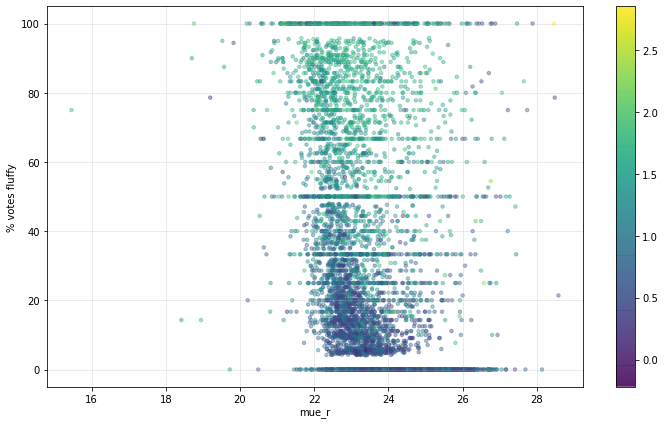

In [30]:
fig, fr = plt.subplots(figsize=(12,7))

sc = fr.scatter(mue_r, fluffy, c=g-r, alpha=0.4, s=12)
cb = fig.colorbar(sc)
cb.solids.set_edgecolor('face')

fr.grid(alpha=0.3)
fr.update({
    'xlabel': 'mue_r',
    'ylabel': "% votes fluffy"
})

plt.savefig('mu vs fluffy votes.png', dpi=450, bbox_inches='tight')
plt.show()

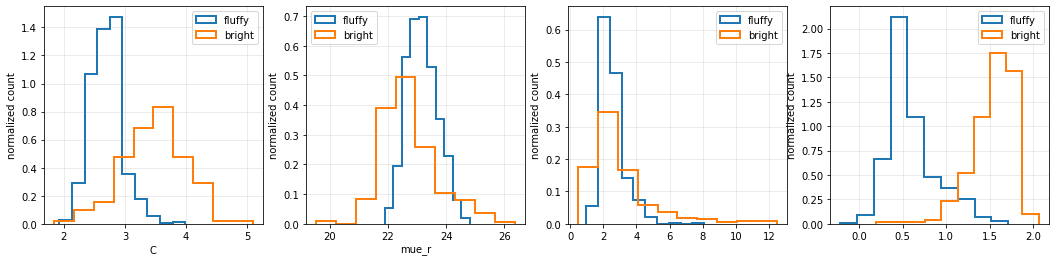

In [24]:
fig, fr = plt.subplots(1,4, figsize=(18,4))

kwargs= { "histtype": "step", "density": True, "lw": 2 }

fr[0].hist(*get_cols(fluf, ['C']), **kwargs, label='fluffy')
fr[0].hist(*get_cols(bright, ['C']), **kwargs, label='bright')

fr[1].hist(*get_cols(fluf, ['mue_r']), **kwargs, label='fluffy')
fr[1].hist(*get_cols(bright, ['mue_r']), **kwargs, label='bright')

fr[2].hist(*get_cols(fluf, ['Reff']), **kwargs, label='fluffy')
fr[2].hist(*get_cols(bright, ['Reff']), **kwargs, label='bright')

g, r = get_cols(fluf, ['g', 'r'])
fr[3].hist(g-r, **kwargs, label='fluffy')
g, r = get_cols(bright, ['g', 'r'])
fr[3].hist(g-r, **kwargs, label='bright')

fr[0].set_xlabel('C')
fr[1].set_xlabel('mue_r')

for i in range(4):
    fr[i].grid(alpha=0.3)
    fr[i].legend()
    fr[i].set_ylabel('normalized count')
    
plt.show()

# Plot task 2 answers vs. color

In [25]:
t2cols = get_column_names('T2', df_votes)
print(t2cols)

['T2', 'T2 % impossible to say', 'T2 % white/blue', 'T2 % red/yellow']


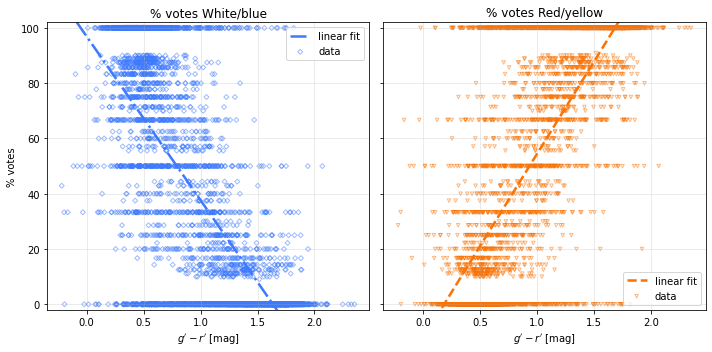

In [29]:
g, r, w_b, r_y = get_cols(df_votes, ['g', 'r', *t2cols[2:]])

fig, fr = plt.subplots(1,2, figsize=(10,5), sharey=True)

kwargs = { "alpha": 0.5, "s": 12, "facecolor": "none" }

fr[0].scatter(g-r, w_b, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="data")
fr[0].plot(*fit_color(r, g, w_b), c='xkcd:lightish blue', lw=2.5, ls='-.', label="linear fit")

fr[1].scatter(g-r, r_y, **kwargs, marker="v", edgecolor="xkcd:orange", label="data")
fr[1].plot(*fit_color(r, g, r_y), c='xkcd:orange', lw=2.5, ls='--', label="linear fit")

for i in range(2):
    fr[i].set_xlabel(r"$g'-r'$ [mag]")

    fr[i].grid(alpha=0.3, which='both')
    fr[i].legend()
    
fr[0].set_title('% votes White/blue')
fr[1].set_title('% votes Red/yellow')
fr[0].set_ylim(-2, 102)
fr[0].set_ylabel('% votes')

fig.tight_layout()
plt.savefig('color vs votes.png', dpi=450, bbox_inches='tight')